<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_3/Aula_5_Outliers_e_validacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando o conteúdo anterior

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [2]:
## df_esp = estado de são paulo
## df_sp = cidade de são paulo

df_esp = pd.read_csv("https://github.com/RPGraciotti/BootCampAlura/blob/main/Data/dados_covid_sp.zip?raw=true", compression = "zip", sep = ";")

df_esp.loc[:,"datahora"] = pd.to_datetime(df_esp.loc[:,"datahora"], format = "%Y-%m-%d")

df_sp = df_esp.query("nome_munic == 'São Paulo'")
df_sp.loc[:,"ano"] = pd.DatetimeIndex(df_sp.loc[:,"datahora"]).year

mpl.rcParams["font.size"] = 18

df2 = pd.DataFrame()
df2.loc[:,"ds"] = df_sp.loc[:,"datahora"][:400]
df2.loc[:,"y"] = df_sp.loc[:,"casos_novos"][:400]

#Usando feriados especificos do municipio de SP (disponível no notebook da aula)

feriados_sp_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2021 = [
'2021-01-01',
'2021-01-25',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]


feriados_sp_2020 = pd.DataFrame({
  'holiday': 'sp_2020',
  'ds': pd.to_datetime(feriados_sp_2020)
})

feriados_sp_2021 = pd.DataFrame({
  'holiday': 'sp_2021',
  'ds': pd.to_datetime(feriados_sp_2021)
})

feriados = pd.concat((feriados_sp_2020, feriados_sp_2021))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


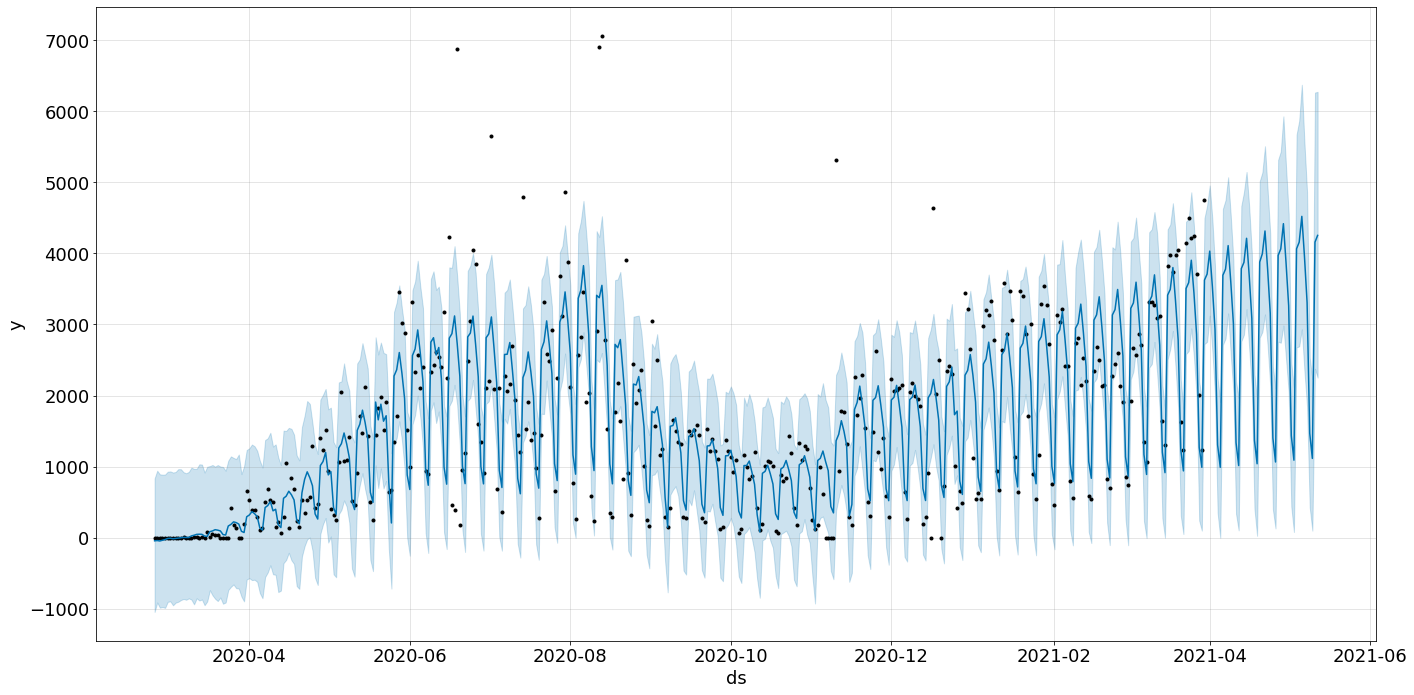

In [3]:
m1 = Prophet(changepoint_prior_scale = 10, holidays = feriados, seasonality_mode = "multiplicative")

m1.fit(df2)
df_prev = m1.make_future_dataframe(periods = 43)

prev = m1.predict(df_prev)

m1.plot(prev, figsize = (20,10));

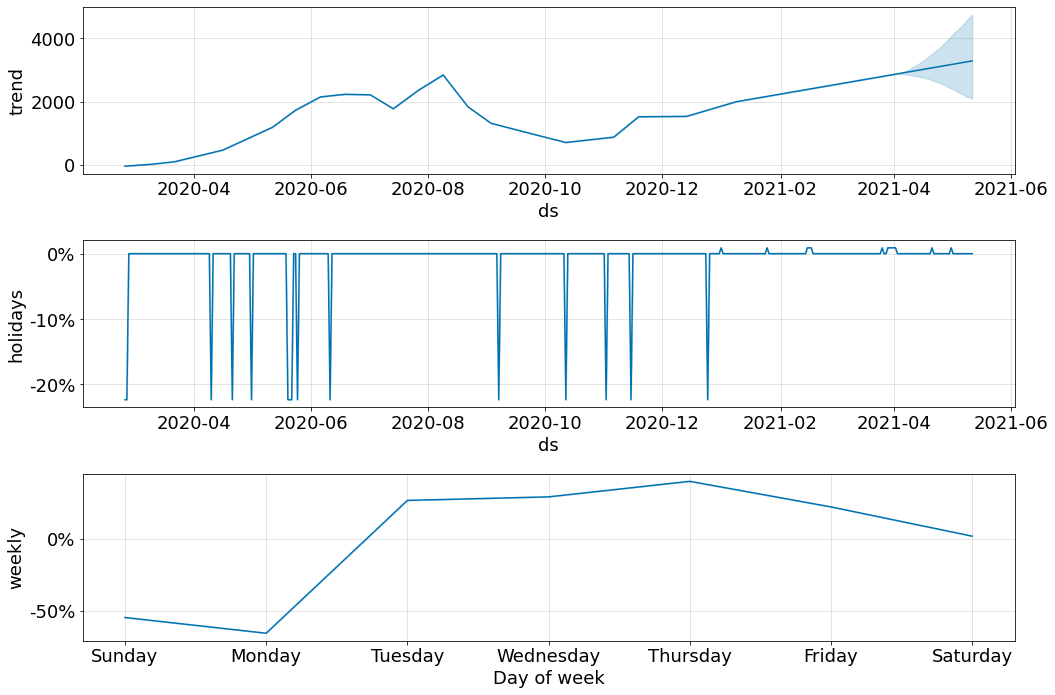

In [4]:
m1.plot_components(prev, figsize = (15,10));

# Sessão 1 - Outliers e intervalo de confiança

#### Exemplo: remover valores fora do intervalo de confiança

In [5]:
novo_y = df2.reset_index()
novo_y

,index,ds,y
0,562,2020-02-25,0
1,1207,2020-02-26,0
2,1852,2020-02-27,0
3,2497,2020-02-28,1
4,3142,2020-02-29,0
...,...,...,...
395,255337,2021-03-26,4241
396,255982,2021-03-27,3709
397,256627,2021-03-28,2010
398,257272,2021-03-29,1242


In [6]:
no_out = novo_y[(novo_y.loc[:,"y"] > prev.loc[:,"yhat_lower"][:400]) & (novo_y.loc[:,"y"] < prev.loc[:,"yhat_upper"][:400])]

In [7]:
no_out.head()

,index,ds,y
0,562,2020-02-25,0
1,1207,2020-02-26,0
2,1852,2020-02-27,0
3,2497,2020-02-28,1
4,3142,2020-02-29,0


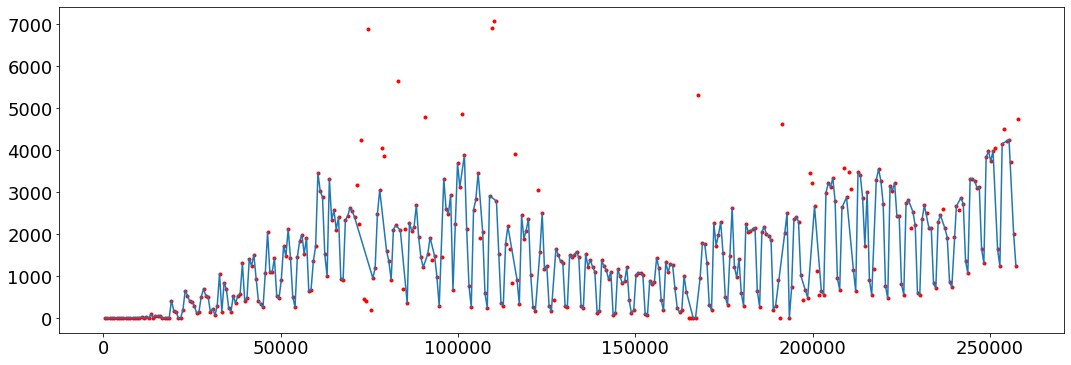

In [8]:
plt.figure(figsize = (18,6))
plt.plot(df2.index, df2.loc[:,"y"], "r.")
plt.plot(no_out.loc[:,"index"], no_out.loc[:,"y"])

In [9]:
df_no_out = no_out.loc[:,["ds", "y"]]
df_no_out.tail()

,ds,y
392,2021-03-23,4149
394,2021-03-25,4214
395,2021-03-26,4241
397,2021-03-28,2010
398,2021-03-29,1242


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


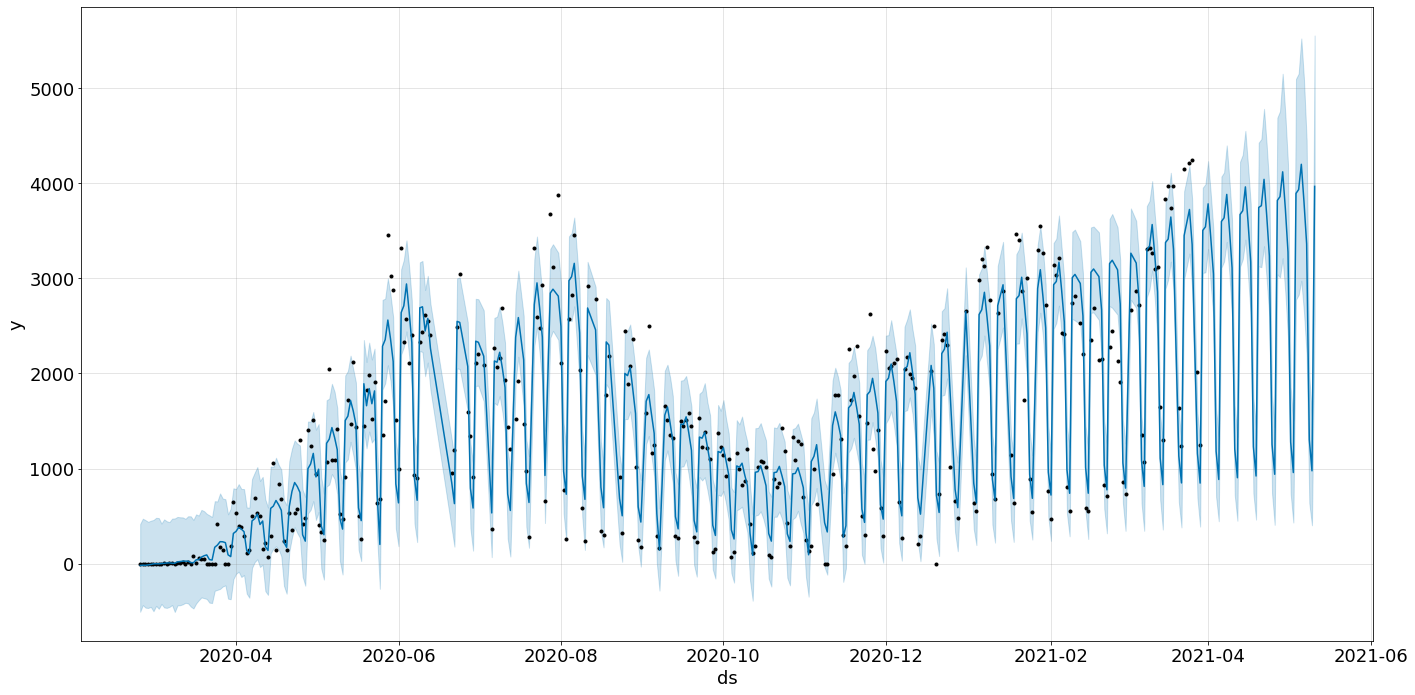

In [10]:
m2 = Prophet(changepoint_prior_scale = 10, holidays = feriados, seasonality_mode = "multiplicative")

m2.fit(df_no_out)

df_prev2 = m2.make_future_dataframe(periods = 43)

prev2 = m2.predict(df_prev2)

m2.plot(prev2, figsize = (20,10));

Durante a aula, houve uma discussão sobre a importância de tratar outliers e os cuidados de se escolher quais remover, ou se remover. Nesse caso da aula, eu escolheria não remover nenhum dado da nossa base de dados, com as informações que temos no momento. Como o Allan mencionou, podem haver casos de falhas no sistema de notificação que alocaram para o dia seguinte, somando um número muito grande de casos neste dia. É uma possibilidade, mas teria que ser investigada com maior conhecimento dos nossos dados.

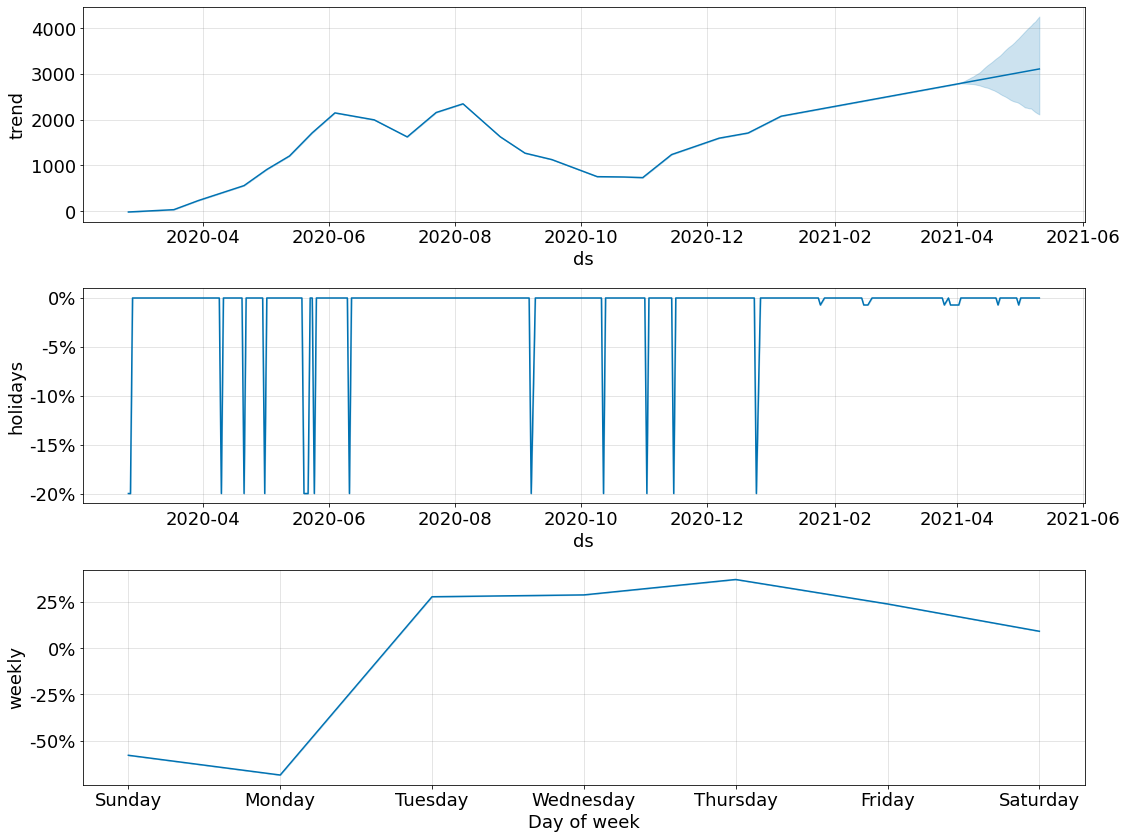

In [11]:
m2.plot_components(prev2, figsize = (16,12));

In [12]:
amostras = m2.predictive_samples(prev2)

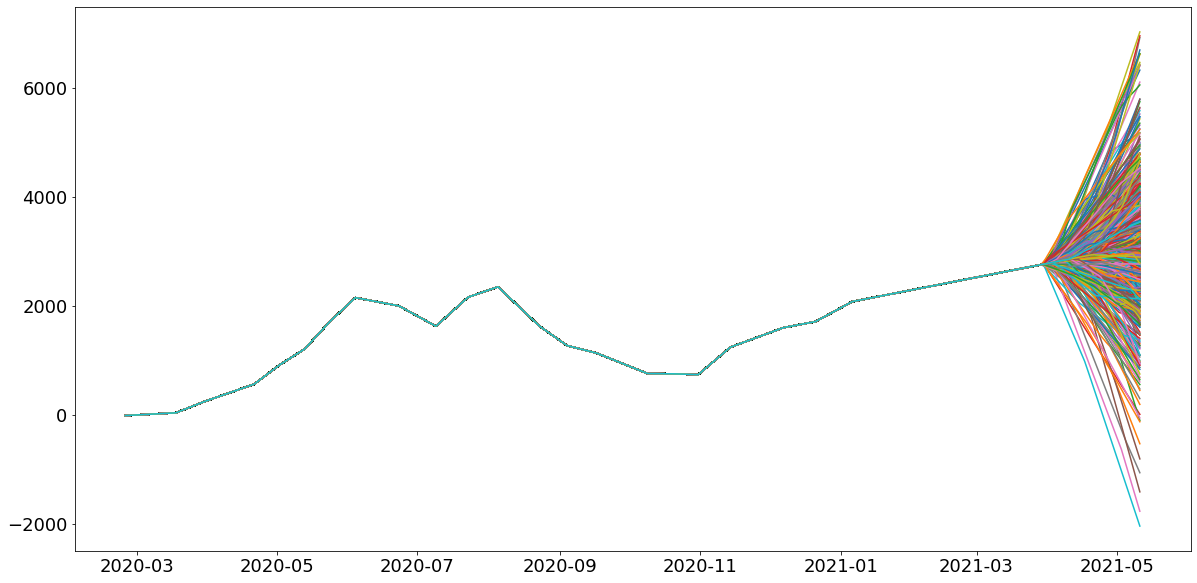

In [13]:
plt.figure(figsize = (20,10))
plt.plot(prev2.loc[:,"ds"], amostras["trend"]);

## Desafio  01 - Testar diferentes intervalos de confiança, testar outras tendências

## Desafio 02 - Plotar os pontos dos dados como feito originalmente, com a linha da previsão

In [14]:
df2_teste = pd.DataFrame()
df2_teste.loc[:,"ds"] = df_sp.loc[:,"datahora"][400:]
df2_teste.loc[:,"y"] = df_sp.loc[:,"casos_novos"][400:]

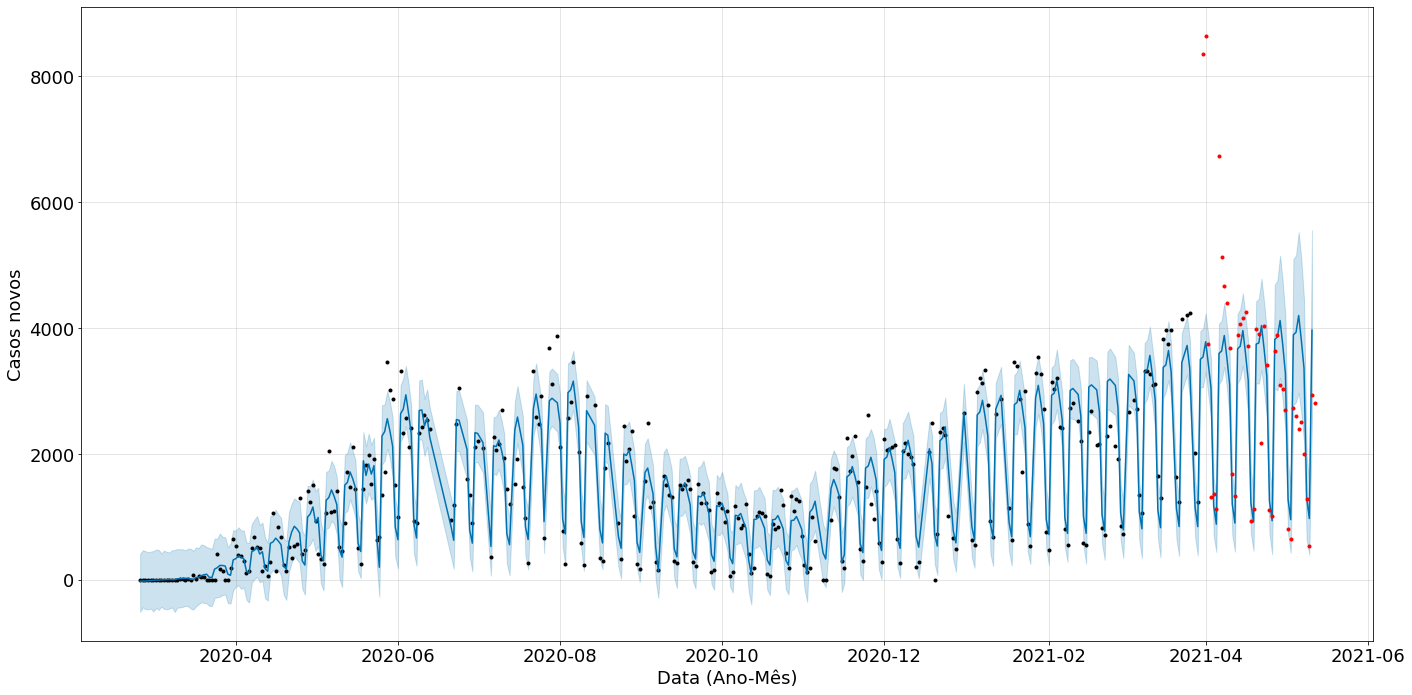

In [15]:
m2.plot(prev2, xlabel = "Data (Ano-Mês)", ylabel = "Casos novos", figsize = (20,10));
plt.plot(df2_teste.loc[:,"ds"], df2_teste.loc[:,"y"], "r.")
plt.show()

# Sessão 2 - Validação cruzada e métricas de avaliação

In [16]:
from fbprophet.diagnostics import cross_validation

In [17]:
df_cv = cross_validation(m2, initial = "180 days", period = "30 days", horizon = "30 days")

INFO:fbprophet:Making 7 forecasts with cutoffs between 2020-08-31 00:00:00 and 2021-02-27 00:00:00


In [18]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-09-02,1924.211978,1473.176314,2347.828670,1579,2020-08-31
1,2020-09-03,1967.311775,1552.001879,2433.093406,2496,2020-08-31
2,2020-09-04,1980.958095,1519.922761,2461.049769,1166,2020-08-31
3,2020-09-05,1558.446320,1091.286433,2058.822982,1245,2020-08-31
4,2020-09-06,645.341134,226.327337,1086.479054,290,2020-08-31


In [19]:
window = 5

cutoff = df_cv.loc[:,"cutoff"].unique()[window]

In [20]:
df_cv_cut = df_cv[df_cv.loc[:,"cutoff"].values == cutoff]

Text(0.5, 0, 'ds')

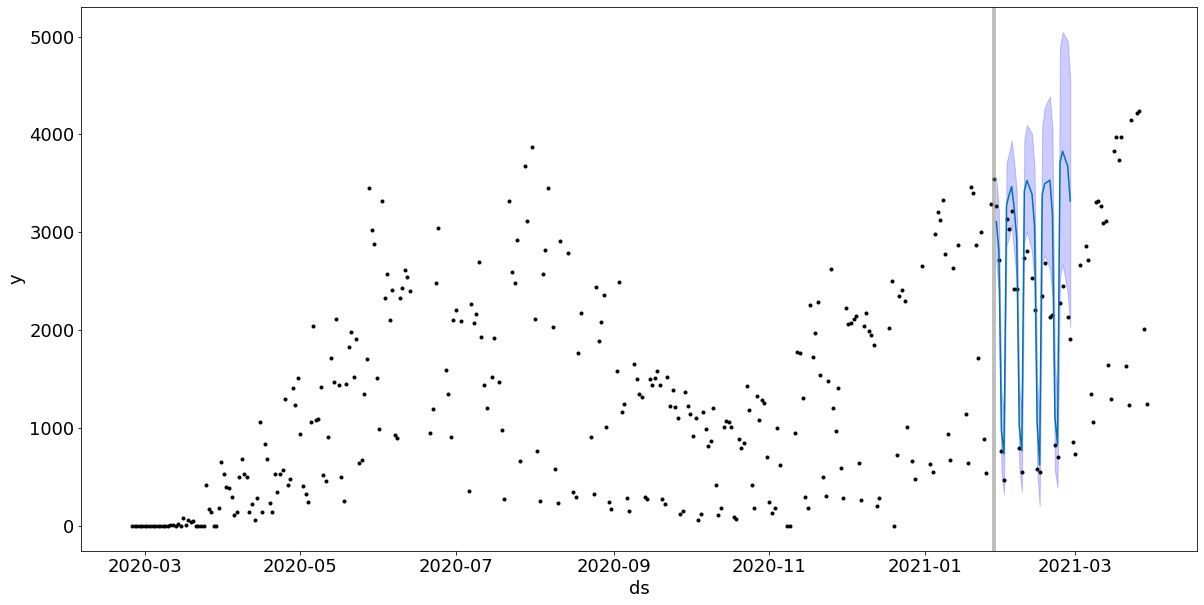

In [21]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111)
ax.plot(m2.history["ds"].values, m2.history["y"], "k.")
ax.plot(df_cv_cut["ds"].values, df_cv_cut["yhat"], ls = "-", c = "#0072B2")
ax.fill_between(df_cv_cut["ds"].values, df_cv_cut["yhat_lower"],
                df_cv_cut["yhat_upper"], color = "blue",
                alpha = 0.2)
ax.axvline(x = pd.to_datetime(cutoff), c = "gray", lw = 4, alpha = 0.5)
ax.set_ylabel("y")
ax.set_xlabel("ds")

In [22]:
from fbprophet.diagnostics import performance_metrics

In [23]:
df_p = performance_metrics(df_cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [24]:
df_p

,horizon,mse,rmse,mae,mdape,coverage
0,4 days,130219.141678,360.858894,286.425097,0.218962,0.777778
1,5 days,120482.311976,347.105621,280.780436,0.207607,0.825397
2,6 days,120676.014156,347.384534,283.675433,0.227582,0.851852
3,7 days,74108.413487,272.228605,225.535545,0.129477,0.944444
4,8 days,137878.752105,371.320282,303.032761,0.164260,0.777778
5,9 days,134691.674143,367.003643,305.505531,0.163254,0.777778
6,10 days,156186.768746,395.204718,348.648243,0.209142,0.755556
7,11 days,117356.726215,342.573680,303.530537,0.209142,0.904762
8,12 days,102477.777049,320.121504,255.926470,0.177038,0.904762
9,13 days,156668.653491,395.813913,297.489168,0.150260,0.833333


## Desafio 03 - Buscar quais métricas se aplicam a quais casos

In [25]:
from fbprophet.plot import plot_cross_validation_metric

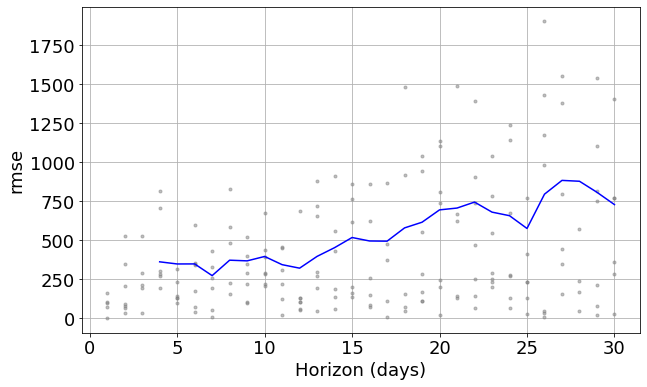

In [29]:
plot_cross_validation_metric(df_cv, metric = "rmse");

In [28]:
ax.shape

AttributeError: ignored